<a href="https://colab.research.google.com/github/lingfang23/CLV-prediction/blob/main/Lifetime_Value_Project_Final_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Google Analytics 360**

New Customer Acquisition Lifetime Value Prediction

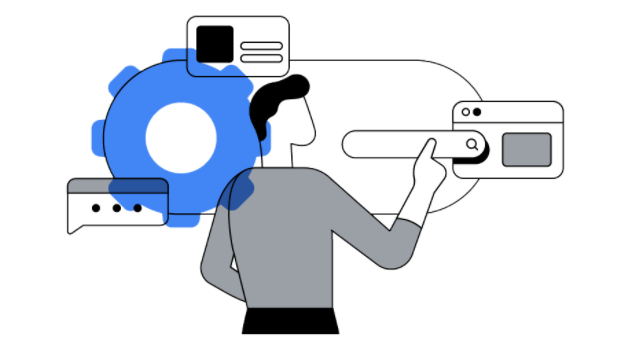

This notebook provides an example of training a customer "lifetime" value model for newly acquired e-commerce customers. It is meant to outline the minimum steps required to train this type of model and can be used as a starting point for your project. It is **not** meant to illustrate best practices or preferred approaches for this type of modeling.

The notebook references publicly available sample of Analytics 360 data, which is accessible through Google Cloud Platform's BigQuery data warehouse. The data was collected from the Google Merchandise Store, which sells Google promotional products like t-shirts, pens, phone accessories, mugs, etc.

For each newly acquired customer, we would like to make an estimate of the *future* revenue we can expect from this customer. We will make a prediction one week after the customer is acquired to estimate their revenue up to 90 days after their acquisition date. By combining this predicted revenue with the actual revenue generated from the customer's first purchase and any subsequent purchase during their first week, we can get a more hollistic view of the value of the acquisition. By providing this value (first transaction revenue + subsequent week 1 revenue + day 8-90 predicted revenue) to Google advertising platforms, Google can automatically optimize digital ads to help acquire higher value new customers.

## Creating training, testing & holdout datasets

In [ ]:
# Authenticate using Google OAuth 2.0
# This will provide the credentials necessary to use Google APIs within this notebook (e.g. BigQuery API)
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
# Query the Analytics 360 sample in BigQuery and store results as a Pandas dataframe
import pandas as pd
import numpy as np
import google.auth
from google.cloud import bigquery
from google.cloud import bigquery_storage

# Change the project to the ID of your personal GCP project
# You can find this ID by going to BQ, clicking on your project name at the top of the UI and finding the ID listed for your project name in the pop-up
project = 'project-501-6'

credentials, project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

bqclient = bigquery.Client(credentials=credentials, project=project,)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

# The query below finds the first transaction of each customer before 05/01/2017
# It summarizes some information from the session where that transaction occurred (e.g. revenue, time on site, page views, etc.)
# It then summarizes some information from subsequent sessions that happen within 7 days of the first transaction session (e.g. additional visits, additional transactions)
# It then sums any subsequent revenue received from that customer over the next 8-90 days, which will be the target for our model
# Again, this is only example query. Feel free to edit and expand on this query to generate better features or a different dataset structure.
# (For example, you could also include data from sessions that happened *before* the customer's acquisition session to help make your prediction...Just don't include data from more than 7 days after their acquisition session!)
# Comments are added within the query. You can copy & paste this query into the BigQuery UI for easier readability
sql = """
WITH first_purchases AS (
# Find the start time for the session when the customer made their first purchase
SELECT 
    fullVisitorId, # Consider this the customer ID
    MIN(PARSE_TIMESTAMP('%s', CAST(visitStartTime AS string))) firstPurchaseSessionTime # This will show "UTC" as the timezone but I think it's actually Pacific
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
    _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
    AND geoNetwork.country = 'United States' # Only looking at US acquisitions so we can assume everything is in USD
GROUP BY
    fullVisitorId
),

first_purchases_sessions AS (
# Get session-level data from the session when the customer made their first purchase
# You'll see later that we have to query session-level data and hit-level data separately
SELECT 
    fp.fullVisitorId,
    ROUND(SUM(totals.transactionRevenue/1000000),2) AS revenue, # I've aggregated all the metrics here but really I don't have to since these are "totals" fields (i.e. session-level) and there will only be one session per customer
    MAX(visitNumber) AS visitNumber,
    SUM(totals.hits) AS hits,
    SUM(totals.pageviews) AS pageviews,
    COALESCE(SUM(totals.timeOnSite),0) AS timeOnSite,
    MAX(CASE WHEN channelGrouping = 'Referral' THEN 1 ELSE 0 END) AS referralChannelGrouping,
    MAX(CASE WHEN channelGrouping = 'Organic Search' THEN 1 ELSE 0 END) AS organicSearchChannelGrouping,
    MAX(CASE WHEN channelGrouping = 'Direct' THEN 1 ELSE 0 END) AS directChannelGrouping,
    MAX(CASE WHEN channelGrouping = 'Paid Search' THEN 1 ELSE 0 END) AS paidSearchChannelGrouping,
    MAX(CASE WHEN device.browser = 'Chrome' THEN 1 ELSE 0 END) AS chromeBrowser,
    MAX(CASE WHEN device.browser = 'Safari' THEN 1 ELSE 0 END) AS safariBrowser,
    MAX(CASE WHEN device.operatingSystem = 'Macintosh' THEN 1 ELSE 0 END) AS macintoshOS,
    MAX(CASE WHEN device.operatingSystem = 'Windows' THEN 1 ELSE 0 END) AS windowsOS,
    MAX(CASE WHEN device.operatingSystem = 'Chrome OS' THEN 1 ELSE 0 END) AS chromeOS,
    MAX(CASE WHEN device.operatingSystem = 'Linux' THEN 1 ELSE 0 END) AS LinuxOS,
    MAX(CASE WHEN device.isMobile IS TRUE THEN 1 ELSE 0 END) AS isMobile, # dummy variable indicating if the customer was on a mobile device
    MAX(CASE WHEN geoNetwork.region = 'California' THEN 1 ELSE 0 END) AS california, # dummy variable indicating if the customer was in California
    MAX(CASE WHEN geoNetwork.region = 'New York' THEN 1 ELSE 0 END) AS newYork, # dummy variable indicating if the customer was in California
    MAX(CASE WHEN geoNetwork.metro = 'San Francisco-Oakland-San Jose CA' THEN 1 ELSE 0 END) AS bayArea,
    MAX(CASE WHEN device.deviceCategory = 'desktop' THEN 1 ELSE 0 END) AS desktop,
    MAX(CASE WHEN device.deviceCategory = 'tablet' THEN 1 ELSE 0 END) AS tablet

FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*` ga
JOIN
    first_purchases fp
ON
    ga.fullVisitorId = fp.fullVisitorId
    AND PARSE_TIMESTAMP('%s', CAST(ga.visitStartTime AS string)) = fp.firstPurchaseSessionTime # Only getting data from first purchase
WHERE
    _TABLE_SUFFIX < '20170501' 
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
    AND geoNetwork.country = 'United States'
GROUP BY
    fp.fullVisitorId
),

first_purchases_hits AS (
# Get hit-level data from the session when the customer made their first purchase
# Hit data is stored in nested fields so we have to query it separately from the session-level data or else the session-level data aggregations would be incorrect
SELECT 
    fp.fullVisitorId,
    SUM(hits.eCommerceAction.step) AS hit_checkstep,
    SUM(CASE WHEN hits.eCommerceAction.action_type = '6' THEN product.productQuantity ELSE 0 END) AS productQuantityPurchased, # Product quantity in the final transaction
    MAX(CASE WHEN product.v2ProductCategory = 'Apparel' AND hits.eCommerceAction.action_type = '6' THEN 1 ELSE 0 END) AS apparelPurchased, # dummy variable indicating if any apparel was purchased
    MAX(CASE WHEN product.v2ProductCategory = 'Office' AND hits.eCommerceAction.action_type = '6' THEN 1 ELSE 0 END) AS officePurchased,# dummy variable indicating if any office supplies were purchased
    MAX(CASE WHEN product.v2ProductCategory = 'Drinkware' AND hits.eCommerceAction.action_type = '6' THEN 1 ELSE 0 END) AS drinkwarePurchased,
    MAX(CASE WHEN product.v2ProductCategory = 'Lifestyle' AND hits.eCommerceAction.action_type = '6' THEN 1 ELSE 0 END) AS lifestylePurchased,
    MAX(CASE WHEN product.v2ProductCategory = 'Bags' AND hits.eCommerceAction.action_type = '6' THEN 1 ELSE 0 END) AS bagsPurchased,
    MAX(CASE WHEN product.v2ProductCategory = 'Electronics' AND hits.eCommerceAction.action_type = '6' THEN 1 ELSE 0 END) AS electronicsPurchased,# dummy variable indicating if any electronics were purchased
    MAX(CASE WHEN hits.eCommerceAction.action_type = '4' THEN 1 ELSE 0 END) AS removedItemFromCart, # dummy variable indicating if they removed something from their cart during the session
 
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*` ga,
    UNNEST(hits) hits,
    UNNEST(hits.product) product
JOIN
    first_purchases fp
ON
    ga.fullVisitorId = fp.fullVisitorId
    AND PARSE_TIMESTAMP('%s', CAST(ga.visitStartTime AS string)) = fp.firstPurchaseSessionTime # Only getting data from first purchase
WHERE
    _TABLE_SUFFIX < '20170501' 
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
    AND geoNetwork.country = 'United States'
GROUP BY
    fp.fullVisitorId
),

# Get session level data that occured after the first purchase session but within 7 days of that session
# Looking to see if the user came back within a week and had any additional activity
first_week_sessions AS (
SELECT 
    fp.fullVisitorId,
    COALESCE(SUM(ga.totals.visits),0) AS firstWeekVisits, # Visits from first week of acquisition, excluding acquisition session
    COALESCE(SUM(ga.totals.transactions),0) AS firstWeekTransactions, # Transactions from first week of acquisition, excluding acquisition session
    COALESCE(ROUND(SUM(ga.totals.transactionRevenue/1000000),2),0) AS firstWeekRevenue, # Revenue from first week of acquisition, excluding acquisition session
FROM 
    first_purchases fp
LEFT JOIN
    `bigquery-public-data.google_analytics_sample.ga_sessions_*` ga
ON 
    fp.fullVisitorId = ga.fullVisitorId
    AND TIMESTAMP_DIFF(PARSE_TIMESTAMP('%s', CAST(ga.visitStartTime AS string)), fp.firstPurchaseSessionTime, HOUR) BETWEEN 1 AND 168 # Consider visits between 1 hour and 7 days after first purchase session
GROUP BY 
    fp.fullVisitorId
),

future_purchases AS (
# For each newly acquired customer, look for any purchases that occurred in the next 8-90 days
SELECT
    fp.fullVisitorId,
    ROUND(SUM(ga.totals.transactionRevenue/1000000),2) AS futureRevenue # This is our model target
FROM 
    first_purchases fp
LEFT JOIN
    `bigquery-public-data.google_analytics_sample.ga_sessions_*` ga
ON 
    fp.fullVisitorId = ga.fullVisitorId
    AND TIMESTAMP_DIFF(PARSE_TIMESTAMP('%s', CAST(ga.visitStartTime AS string)), fp.firstPurchaseSessionTime, DAY) BETWEEN 8 AND 90 # Consider purchases between 8-90 days after acquisition
WHERE 
    ga.totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY 
    fp.fullVisitorId
),

purchase_frq AS (
SELECT 
    fp.fullVisitorId, # Consider this the customer ID
    count(hits.eCommerceAction.action_type = "6") as Frequency

FROM 
    first_purchases as fp

LEFT JOIN 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*` ga
ON 
    fp.fullVisitorId = ga.fullVisitorId, UNNEST(hits) hits

WHERE
    totals.transactions > 0
    AND totals.transactionRevenue > 0
    AND TIMESTAMP_DIFF(PARSE_TIMESTAMP('%s', CAST(ga.visitStartTime AS string)), fp.firstPurchaseSessionTime, DAY) <= 90
    AND geoNetwork.country = 'United States'
GROUP BY
    fullVisitorId
),

time_purchase AS (
SELECT 
    fp.fullVisitorId, 
    PARSE_TIMESTAMP('%s', CAST(visitStartTime AS string)) as purchase_time,
    date(firstPurchaseSessionTime) as date_format_purchase,
FROM 
    first_purchases as fp

LEFT JOIN 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*` ga
ON 
    fp.fullVisitorId = ga.fullVisitorId
WHERE
    totals.transactions > 0
    AND totals.transactionRevenue > 0
    AND geoNetwork.country = 'United States' 
),

rank_time AS (
select fullVisitorId, purchase_time,
rank() over(partition by fullVisitorId order by purchase_time asc) as d_rank 
from time_purchase 
group by fullVisitorId, purchase_time
),

first_time AS(
SELECT fullVisitorId, purchase_time as first_buy
FROM rank_time
WHERE d_rank = 1
),

second_time AS(
SELECT  fullVisitorId, purchase_time as second_buy
FROM rank_time
WHERE d_rank = 2
),

interval_date AS(
select fullVisitorId, COALESCE(date_diff(second_buy, first_buy, hour), 169) as purchase_interval_hr
from (select ft.fullVisitorId, first_buy, second_buy from first_time ft left join second_time st
on ft.fullVisitorId = st.fullVisitorId) as first_second_buy
),

week_day AS (
SELECT fullVisitorId, (CASE WHEN weekday_name = "Fri" or weekday_name = "Sat" or weekday_name = "Sun" then 1 else 0 end) as buy_weekend
FROM(
    SELECT fullVisitorId, FORMAT_DATE("%a", date_format_purchase) as weekday_name FROM time_purchase)
)



# Join the list of newly acquired customers to their acquisition session-level data, acquisition hit-level data, first week session-level data, and future day 8-90 revenue
SELECT
    distinct first_purchases.*,
    first_purchases_sessions.* EXCEPT(fullVisitorId),
    first_purchases_hits.* EXCEPT(fullVisitorId),
    first_week_sessions.* EXCEPT(fullVisitorId),
    purchase_frq.* EXCEPT(fullVisitorId),
    COALESCE(future_purchases.futureRevenue,0) AS futureRevenue,
    (CASE WHEN purchase_interval_hr <= 168 THEN purchase_interval_hr ELSE 169 END) AS purchase_interval_hr,
    week_day.buy_weekend,
FROM 
    first_purchases
LEFT JOIN 
    first_purchases_sessions 
USING(fullVisitorId)
LEFT JOIN 
    first_purchases_hits 
USING(fullVisitorId)
LEFT JOIN 
    future_purchases 
USING(fullVisitorId)
LEFT JOIN
    first_week_sessions 
USING(fullVisitorId)
LEFT JOIN
    purchase_frq
USING(fullVisitorId)
LEFT JOIN
    interval_date 
USING(fullVisitorId)
LEFT JOIN
    week_day 
USING(fullVisitorId)


"""

# Store query results as Panada dataframe
df = pd.read_gbq(sql, project_id=project, dialect='standard', use_bqstorage_api=True)

/usr/local/lib/python3.7/dist-packages/google/cloud/bigquery_storage_v1beta1/reader.py:603: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  df[column] = pandas.Series(df[column], dtype=dtypes[column])


In [ ]:
df.head()

,fullVisitorId,firstPurchaseSessionTime,revenue,visitNumber,hits,pageviews,timeOnSite,referralChannelGrouping,organicSearchChannelGrouping,directChannelGrouping,...,bagsPurchased,electronicsPurchased,removedItemFromCart,firstWeekVisits,firstWeekTransactions,firstWeekRevenue,Frequency,futureRevenue,purchase_interval_hr,buy_weekend
0,3845150128833861321,2016-08-15 21:32:54+00:00,91.28,1,32,23,375,0,0,1,...,0,0,1,0,0,0.0,32,0.0,169,0
1,7524315936765112211,2016-09-05 02:03:30+00:00,32.94,1,75,52,1300,0,1,0,...,0,0,0,0,0,0.0,75,0.0,169,0
2,5756208439960248003,2016-08-19 22:40:14+00:00,81.39,2,25,20,251,0,1,0,...,0,0,0,0,0,0.0,25,0.0,169,1
3,6298030765010140996,2017-04-07 06:31:06+00:00,27.98,1,20,16,525,0,1,0,...,0,0,0,0,0,0.0,20,0.0,169,1
4,971721932033460269,2016-11-16 23:06:20+00:00,8.99,1,43,31,492,0,1,0,...,0,0,0,0,0,0.0,43,0.0,169,0


In [ ]:
df.describe()

,revenue,visitNumber,hits,pageviews,timeOnSite,referralChannelGrouping,organicSearchChannelGrouping,directChannelGrouping,paidSearchChannelGrouping,chromeBrowser,...,bagsPurchased,electronicsPurchased,removedItemFromCart,firstWeekVisits,firstWeekTransactions,firstWeekRevenue,Frequency,futureRevenue,purchase_interval_hr,buy_weekend
count,6913.000000,6913.000000,6913.000000,6913.000000,6913.000000,6913.000000,6913.000000,6913.000000,6913.000000,6913.000000,...,6913.000000,6913.000000,6913.000000,6913.000000,6913.000000,6913.000000,6913.000000,6913.000000,6913.000000,6913.000000
mean,115.936457,2.730508,37.360046,29.244322,1052.574714,0.464921,0.306958,0.165919,0.040937,0.894547,...,0.083177,0.061912,0.217850,0.510054,0.038623,4.584898,42.267178,29.028474,165.781426,0.327354
std,377.814055,4.471763,29.142884,20.536469,914.685852,0.498804,0.461265,0.372035,0.198159,0.307159,...,0.276169,0.241014,0.412815,1.230258,0.293321,53.266724,39.897734,634.200233,20.382329,0.469282
min,0.010000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
25%,23.960000,1.000000,19.000000,17.000000,463.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,169.000000,0.000000
50%,46.980000,2.000000,30.000000,24.000000,780.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.000000,0.000000,169.000000,0.000000
75%,99.990000,3.000000,46.000000,36.000000,1342.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,50.000000,0.000000,169.000000,1.000000
max,17855.500000,181.000000,500.000000,466.000000,15047.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,27.000000,13.000000,2106.290000,632.000000,50941.850000,169.000000,1.000000


In [ ]:
print(sum(df.futureRevenue==0))
print(sum(df.purchase_interval_hr==169))

6412
6702


In [ ]:
df["hit_checkstep"].describe()

count    6913.000000
mean      148.505280
std       181.220176
min         4.000000
25%        44.000000
50%        93.000000
75%       186.000000
max      5023.000000
Name: hit_checkstep, dtype: float64

In [ ]:
df.isnull().sum()

fullVisitorId                   0
firstPurchaseSessionTime        0
revenue                         0
visitNumber                     0
hits                            0
pageviews                       0
timeOnSite                      0
referralChannelGrouping         0
organicSearchChannelGrouping    0
directChannelGrouping           0
paidSearchChannelGrouping       0
chromeBrowser                   0
safariBrowser                   0
macintoshOS                     0
windowsOS                       0
chromeOS                        0
LinuxOS                         0
isMobile                        0
california                      0
newYork                         0
bayArea                         0
desktop                         0
tablet                          0
hit_checkstep                   0
productQuantityPurchased        0
apparelPurchased                0
officePurchased                 0
drinkwarePurchased              0
lifestylePurchased              0
bagsPurchased 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6913 entries, 0 to 6912
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype              
---  ------                        --------------  -----              
 0   fullVisitorId                 6913 non-null   object             
 1   firstPurchaseSessionTime      6913 non-null   datetime64[ns, UTC]
 2   revenue                       6913 non-null   float64            
 3   visitNumber                   6913 non-null   int64              
 4   hits                          6913 non-null   int64              
 5   pageviews                     6913 non-null   int64              
 6   timeOnSite                    6913 non-null   int64              
 7   referralChannelGrouping       6913 non-null   int64              
 8   organicSearchChannelGrouping  6913 non-null   int64              
 9   directChannelGrouping         6913 non-null   int64              
 10  paidSearchChannelGrouping     6913 n

In [ ]:
duplicate=df.duplicated('fullVisitorId')
print(duplicate.sum())

0


In [ ]:
# Create development and holdout datasets
# Dev data will be further split into training and testing data
# The holdout data will be used to get a final estimate of the model's performance
dev_data = df[(df.firstPurchaseSessionTime < '2017-04-01 00:00:00 UTC')]
holdout_data = df[(df.firstPurchaseSessionTime >= '2017-04-01 00:00:00 UTC')]

In [ ]:
df.firstPurchaseSessionTime.sort()

## Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install yellowbrick

## Exploratory Data Analysis
1. Correlation
2. Iddentify Outliers
3. Data Distribution (histogram)

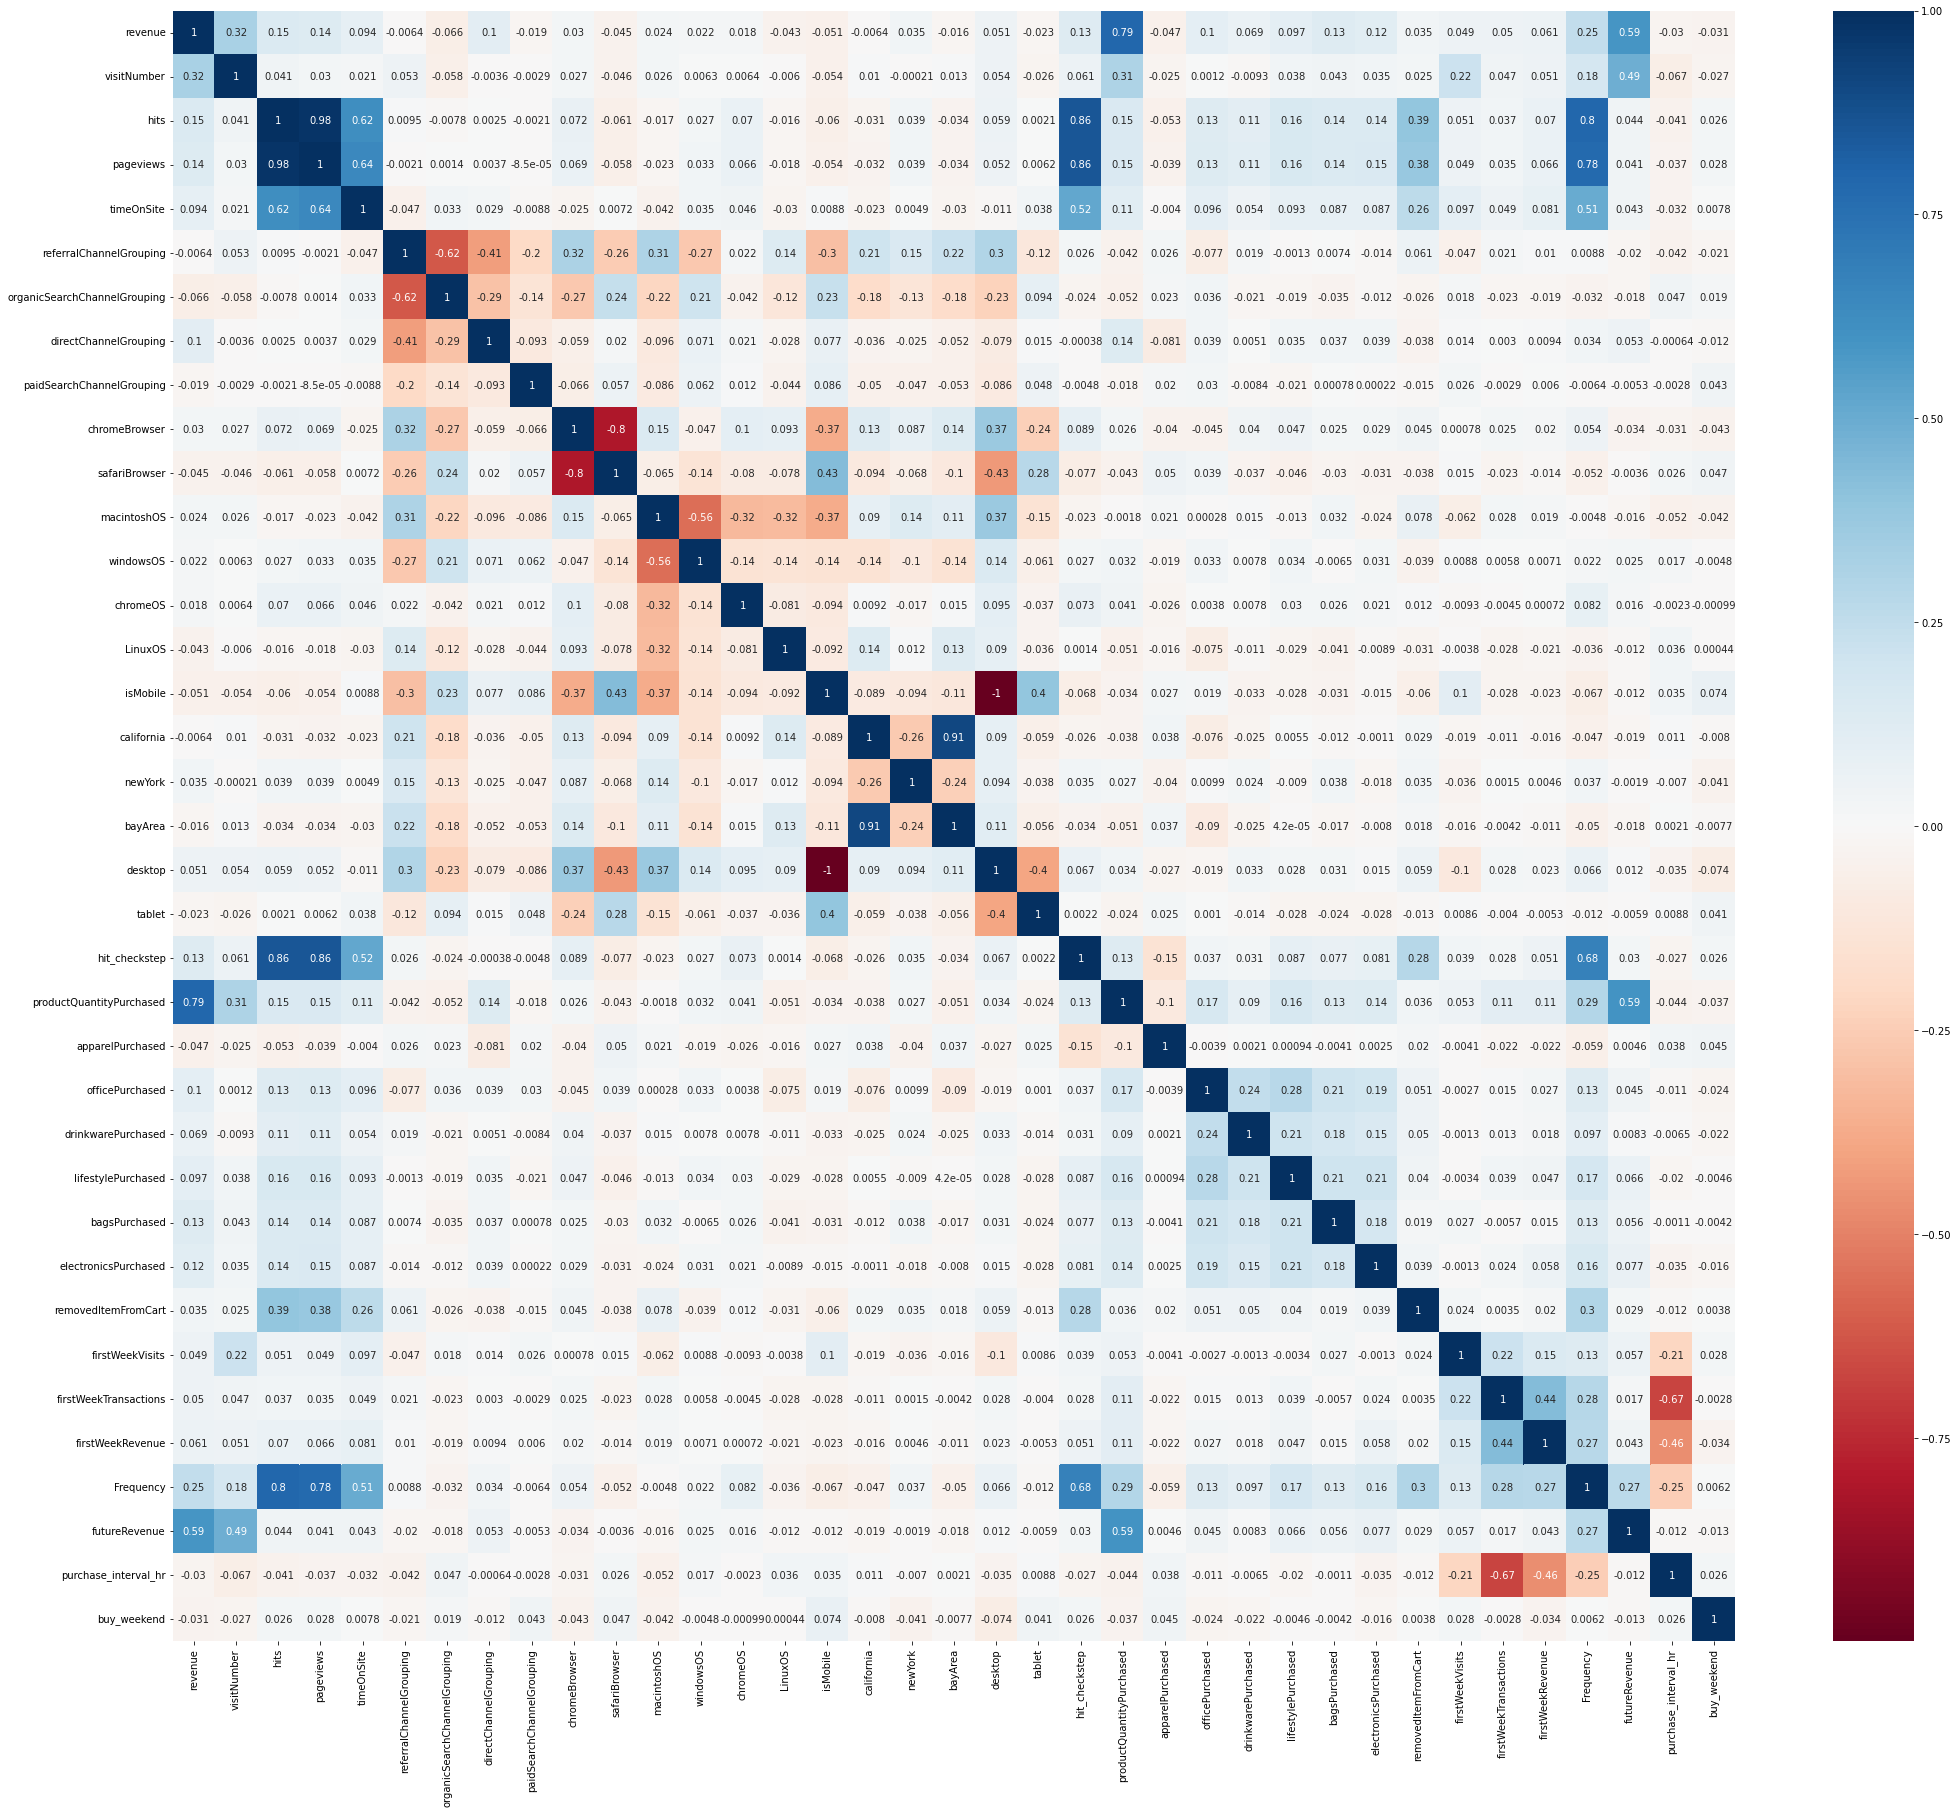

In [ ]:
# Correlation on Variables
plt.figure(figsize=(35,30))
sns.heatmap(dev_data.corr(),cbar=True,annot=True,cmap='RdBu')

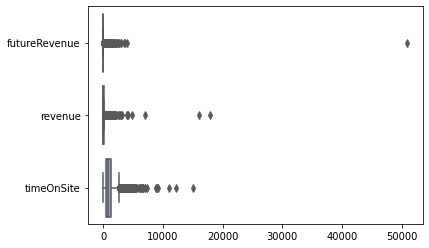

In [ ]:
boxplot_1 = sns.boxplot(data=dev_data[['futureRevenue', 'revenue', 'timeOnSite']], orient="h", palette="Set2")

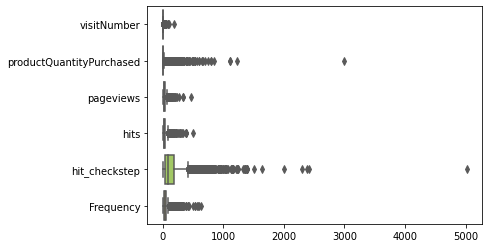

In [ ]:
boxplot_2 = sns.boxplot(data=dev_data[['visitNumber', 'productQuantityPurchased', 'pageviews', 'hits', 'hit_checkstep', 'Frequency']], orient="h", palette="Set2")

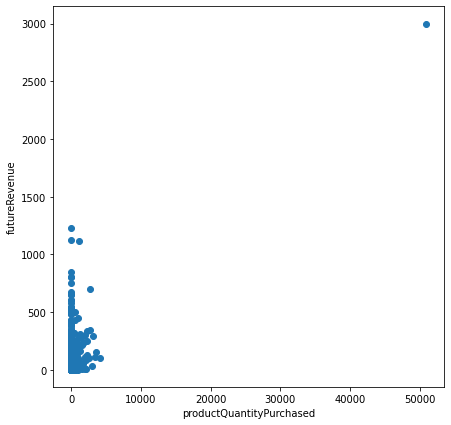

In [ ]:
# Scatter plot
fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(dev_data['futureRevenue'], dev_data['productQuantityPurchased'])
 
# x-axis label
ax.set_xlabel('productQuantityPurchased')
 
# y-axis label
ax.set_ylabel('futureRevenue')
plt.show()

## Data Processing
1. Drop records with outlier values
2. Setup the data for Standardization, Log Transform, and SK Learn
3. Standardization of dependent variables
4. Log transform skewed data 

In [ ]:
# Drop records with outlier values
dev_data = dev_data.drop(
                    dev_data[(dev_data['futureRevenue'] >= 10000.00) 
                    | (dev_data['revenue'] >= 5000.00)
                    | (dev_data['visitNumber'] >= 150) 
                    | (dev_data['productQuantityPurchased'] >= 1500)
                    | (dev_data['pageviews'] >= 400)
                    | (dev_data['timeOnSite'] >= 10000)
                    | (dev_data['hits'] >= 500)
                    | (dev_data['hit_checkstep'] >= 5000)
                    | (dev_data['Frequency'] >= 600)].index)

In [ ]:
dev_data.describe()

,revenue,visitNumber,hits,pageviews,timeOnSite,referralChannelGrouping,organicSearchChannelGrouping,directChannelGrouping,paidSearchChannelGrouping,chromeBrowser,...,bagsPurchased,electronicsPurchased,removedItemFromCart,firstWeekVisits,firstWeekTransactions,firstWeekRevenue,Frequency,futureRevenue,purchase_interval_hr,buy_weekend
count,6133.000000,6133.000000,6133.000000,6133.00000,6133.000000,6133.000000,6133.000000,6133.000000,6133.000000,6133.000000,...,6133.000000,6133.000000,6133.000000,6133.000000,6133.000000,6133.000000,6133.000000,6133.000000,6133.000000,6133.000000
mean,110.831409,2.740584,37.886189,29.65759,1050.282407,0.467471,0.304745,0.163541,0.042557,0.893690,...,0.079080,0.060655,0.216207,0.514593,0.038643,4.814572,42.834828,22.401044,165.771890,0.322191
std,229.103241,4.049922,28.411065,19.60465,875.620795,0.498981,0.460337,0.369889,0.201872,0.308259,...,0.269886,0.238717,0.411691,1.240617,0.298900,55.874471,38.944827,168.729762,20.435019,0.467354
min,0.010000,1.000000,2.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
25%,23.970000,1.000000,20.000000,17.00000,466.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,169.000000,0.000000
50%,47.430000,2.000000,30.000000,25.00000,783.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000,0.000000,169.000000,0.000000
75%,100.770000,3.000000,47.000000,37.00000,1344.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,51.000000,0.000000,169.000000,1.000000
max,4847.600000,109.000000,387.000000,341.00000,9275.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,27.000000,13.000000,2106.290000,582.000000,4075.120000,169.000000,1.000000


In [ ]:
X_origin = dev_data.drop(['fullVisitorId', 'firstPurchaseSessionTime','futureRevenue'], axis=1)

### Setup the data for Standardization, Log Transform, and SK Learn

In [ ]:
from sklearn import preprocessing

In [ ]:
# Setup the data for Standardization, Log Transformation, and SK Learn
X_sd = dev_data.drop(['fullVisitorId', 'firstPurchaseSessionTime','futureRevenue'], axis=1) 
X_log = dev_data.drop(['fullVisitorId', 'firstPurchaseSessionTime','futureRevenue'], axis=1)
y = pd.Series(dev_data.futureRevenue) # Target vector in pd.Series format

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f50b19bbbd0>,
      dtype=object)

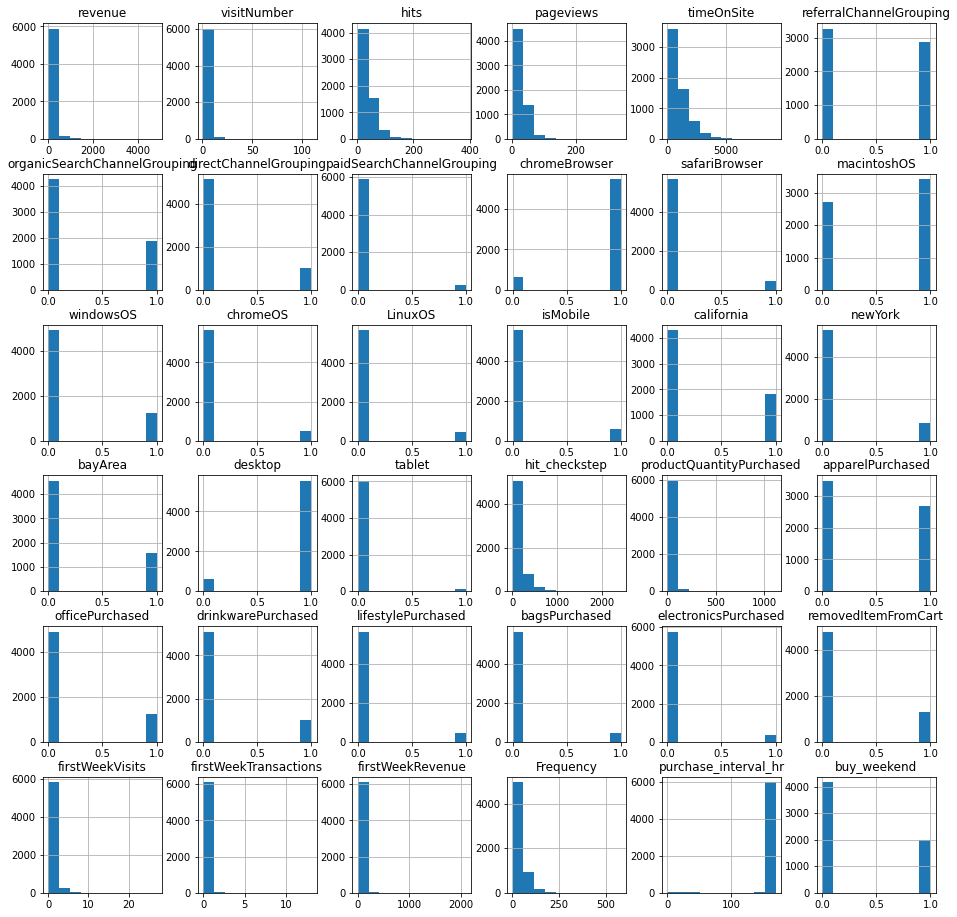

In [ ]:
# Check Data Distribution (histogram)
X_origin.hist(figsize=(16, 16))

In [ ]:
# Standardization of dependent variables_orgin
X_sd = preprocessing.scale(X_sd)
print(X_sd)
# fig = plt.figure(figsize =(10, 7))
# hist_X = plt.hist(X_sd[0], bins=[i for i in np.arange(-1, 1, 0.1)])
# plt.title("Histogram of scale")
# plt.show()

[[-0.40090615 -0.1828786  -0.91120485 ... -0.79182126  0.1579824
  -0.68945108]
 [ 0.24802453 -0.42981705 -0.7000023  ... -0.63774459  0.1579824
  -0.68945108]
 [-0.30587573 -0.42981705 -0.27759721 ... -0.32959126  0.1579824
  -0.68945108]
 ...
 [-0.31801099 -0.42981705  0.35601042 ...  1.75044377  0.1579824
  -0.68945108]
 [-0.30583208 -0.42981705 -0.7000023  ... -0.63774459  0.1579824
  -0.68945108]
 [-0.13462893  0.31099831 -0.77040315 ... -0.68910348  0.1579824
  -0.68945108]]


In [ ]:
# Log transformation to solve skewed data 
scale_c = ["revenue", "visitNumber", "hits", "pageviews", "timeOnSite", "hit_checkstep", 
           "productQuantityPurchased", "firstWeekVisits",	"firstWeekTransactions",	"firstWeekRevenue",	"Frequency", "purchase_interval_hr"]
X_log[scale_c] = X_log[scale_c]+1
X_log.head()

,revenue,visitNumber,hits,pageviews,timeOnSite,referralChannelGrouping,organicSearchChannelGrouping,directChannelGrouping,paidSearchChannelGrouping,chromeBrowser,...,lifestylePurchased,bagsPurchased,electronicsPurchased,removedItemFromCart,firstWeekVisits,firstWeekTransactions,firstWeekRevenue,Frequency,purchase_interval_hr,buy_weekend
0,19.99,3,13,13,476,1,0,0,0,1,...,0,0,0,0,1,1,1.0,13,170,0
1,168.65,2,19,15,421,1,0,0,0,1,...,0,0,0,0,2,1,1.0,19,170,0
2,41.76,2,31,23,1187,1,0,0,0,1,...,1,0,0,1,1,1,1.0,31,170,0
3,167.61,2,62,49,2066,0,1,0,0,1,...,1,0,1,0,2,1,1.0,62,170,0
5,10.99,2,61,44,865,0,1,0,0,1,...,0,0,0,0,2,1,1.0,61,170,1


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


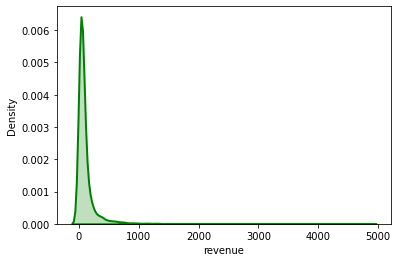

In [ ]:
sns.distplot(X_log["revenue"], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Non-Normal", color ="green")

In [ ]:
from scipy.stats import boxcox 
for i in scale_c:
  X_log[i], best_lambda = boxcox(X_log[i]) 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


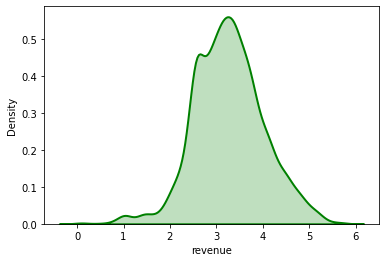

In [ ]:
sns.distplot(X_log["revenue"], hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 2}, 
             label = "Non-Normal", color ="green")

In [ ]:
import xgboost as xgb
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, r2_score, precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import prediction_error
from yellowbrick.regressor import ResidualsPlot

## Regression Model Training
1. Lasso Regression
2. Decision Tree
3. Randomforest
4. XGBoost



### **1.** **Lasso Regression**

In [ ]:
from numpy import mean
from numpy import absolute
from numpy import sqrt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [ ]:
# # # Hyperparameter Tuning using GridSearchCV:search for the best alpha(lambda) value (weights on the coefficients)
# # # define model
# model=Lasso()

# # grid search hyperparameters for Lasso Regression
# from numpy import arange
# from pandas import read_csv
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RepeatedKFold

# # define model evaluation method
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=123) # random state = 123?
# # define grid
# grid = dict()
# grid['alpha'] = arange(0, 1, 0.01)
# # define search
# search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# # perform the search
# results = search.fit(X_vif, y)
# # summarize
# print('MAE: %.3f' % results.best_score_)
# print('Config: %s' % results.best_params_)

# # # Best Result: alpha= 0.99


Training RMSE:  124.92
Training R-Squared:  0.45

Testing RMSE:  145.54
Testing R-Squared:  0.25

Prediction Error Plot


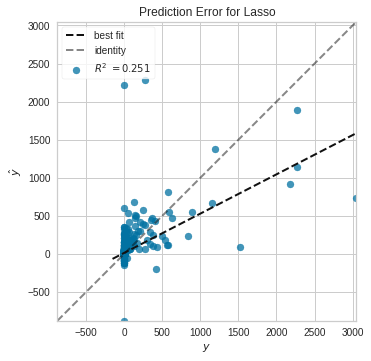

In [ ]:
# Making train and test sets for both X and y
X_train, X_test, y_train, y_test = train_test_split(X_sd,y, test_size=0.2, 
                                                    random_state=123, shuffle=True)

# Instantiate Lasso Regression Model using Hyperparameter Tuning(alpha=0.99)
model=Lasso(alpha=0.99)
#model= LinearRegression()

# Fit the data(train the model)
model.fit(X_train, y_train)

# Calculate RMSE and R^2 for training data
train_y_pred = model.predict(X_train)# Predictions for training data
train_y_true = y_train # True values for training data

Training_MSE = mse(train_y_true, train_y_pred)
Training_RMSE = np.sqrt(Training_MSE)

Training_R_squared = r2_score(train_y_true, train_y_pred)

# Calculate RMSE and R^2 for testing data
test_y_pred = model.predict(X_test) # Predictions for testing data
test_y_true = y_test # True values for testing data

Testing_MSE = mse(test_y_true, test_y_pred)
Testing_RMSE = np.sqrt(Testing_MSE)

Testing_R_squared = r2_score(test_y_true, test_y_pred)

# Print evaluation metrics
print("\nTraining RMSE: ", np.round(Training_RMSE, 2))
print("Training R-Squared: ", np.round(Training_R_squared, 2))

print("\nTesting RMSE: ", np.round(Testing_RMSE, 2))
print("Testing R-Squared: ", np.round(Testing_R_squared, 2))

# Visualize the Prediction Error Plot
print("\nPrediction Error Plot")
viz = prediction_error(model, X_train, y_train, X_test, y_test)
viz.show() # Sometimes visualization fails after using PyCaret EDA... Have to restart runtime and skip EDA

*Feature Importance from Lasso Regression*

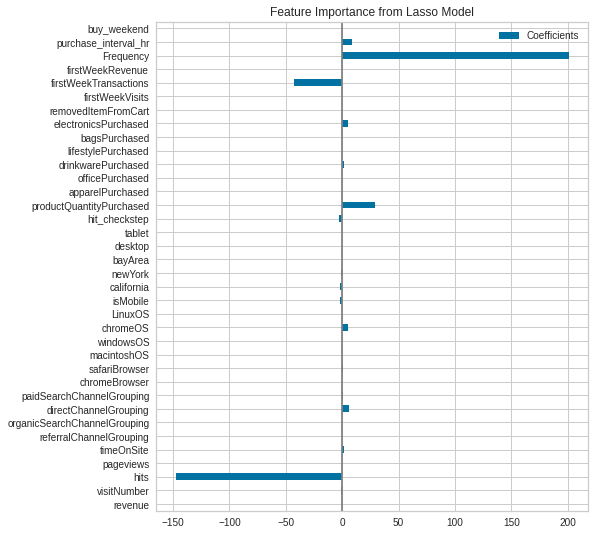

In [ ]:
X = pd.DataFrame(X_sd, columns = X_origin.columns)
coefs = pd.DataFrame(
   model.coef_,
   columns=['Coefficients'], index=X.columns
)

coefs.plot(kind='barh', figsize=(10, 9))
plt.title('Feature Importance from Lasso Model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

*Holdout Data Prediction*

In [ ]:
# Calculate average future revenue observed in the development dataset
AvgCLV = np.mean(dev_data['futureRevenue']) 

# Create naive estimate for all customers, which is equal to average future revenue from development dataset
holdout_data['NaiveEstimate'] = AvgCLV 

# Set up holdout data for initial model
#X_holdout_vif = holdout_data.drop(['fullVisitorId', 'firstPurchaseSessionTime','futureRevenue','NaiveEstimate','hits', 'pageviews','referralChannelGrouping', 'organicSearchChannelGrouping','chromeBrowser','macintoshOS','windowsOS','chromeOS','LinuxOS','isMobile','desktop','purchase_interval_hr'], axis=1) 
X_holdout = holdout_data.drop(['fullVisitorId', 'firstPurchaseSessionTime','futureRevenue','NaiveEstimate'], axis=1) 
y_holdout = pd.Series(holdout_data.futureRevenue)

# # Standardization of dependent variables
#X_holdout_vif = preprocessing.scale(X_holdout_vif)
X_holdout = preprocessing.scale(X_holdout)

holdout_y_pred = model.predict(X_holdout) # Initial model predictions for holdout data
holdout_y_true = y_holdout # True values for holdout data

# Set up data for regression only model
# reg_X_holdout = holdout_data[['revenue','pageviews','referralChannelGrouping','directChannelGrouping','electronicsPurchased','officePurchased','chromeOS','productQuantityPurchased','firstWeekRevenue']]
reg_X_holdout = X_holdout
reg_holdout_y_pred = model.predict(reg_X_holdout)# Regression only predictions for holdout data


# Get RMSE and MAE error based on naive estimate
Naive_MAE = np.mean(np.absolute(pd.Series(holdout_data.NaiveEstimate) - holdout_y_true))
Naive_MSE = mse(pd.Series(holdout_data.NaiveEstimate), holdout_y_true)
Naive_RMSE = np.sqrt(Naive_MSE)
Naive_Avg_Error = np.mean(pd.Series(holdout_data.NaiveEstimate) - holdout_y_true)

# Get RMSE, MAE, and average error based on initial model predictions
Initial_Model_MAE = np.mean(np.absolute(holdout_y_true - holdout_y_pred))
Initial_Model_MSE = mse(holdout_y_true, holdout_y_pred)
Initial_Model_RMSE = np.sqrt(Initial_Model_MSE)
Initial_Model_Avg_Error = np.mean(holdout_y_true - holdout_y_pred)

# Get RMSE and MAE error based on regression only model
Reg_Model_MAE = np.mean(np.absolute(holdout_y_true - reg_holdout_y_pred))
Reg_Model_MSE = mse(holdout_y_true, reg_holdout_y_pred)
Reg_Model_RMSE = np.sqrt(Reg_Model_MSE)
Reg_Model_Avg_Error = np.mean(reg_holdout_y_pred - holdout_y_true)

print("\nNaive MAE: ", np.round(Naive_MAE, 2))
print("Naive RMSE: ", np.round(Naive_RMSE, 2))
print("Naive Avg Error: ", np.round(Naive_Avg_Error, 2))

print("\nInitial Model MAE: ", np.round(Initial_Model_MAE, 2))
print("Initial Model RMSE: ", np.round(Initial_Model_RMSE, 2))
print("Initial Model Avg Error: ", np.round(Initial_Model_Avg_Error, 2))

print("\nRegression Only Model MAE: ", np.round(Reg_Model_MAE, 2))
print("Regression Only Model RMSE: ", np.round(Reg_Model_RMSE, 2))
print("Regression Only Model Avg Error: ", np.round(Reg_Model_Avg_Error, 2))




Naive MAE:  31.19
Naive RMSE:  70.13
Naive Avg Error:  10.35

Initial Model MAE:  35.53
Initial Model RMSE:  79.08
Initial Model Avg Error:  -10.93

Regression Only Model MAE:  35.53
Regression Only Model RMSE:  79.08
Regression Only Model Avg Error:  10.93


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### **2.** **Decision Tree**

In [ ]:
#2. Decision Tree

# import numpy package for arrays and stuff
import numpy as np  

# import matplotlib.pyplot for plotting our result
import matplotlib.pyplot as plt
  
# import pandas for importing csv files 
import pandas as pd
from sklearn import datasets
from sklearn import tree
%matplotlib inline

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_origin,y, test_size=0.2, 
                                                    random_state=123, shuffle=True)

# import the regressor
from sklearn.tree import DecisionTreeRegressor 
  
# create a regressor object
regressor = DecisionTreeRegressor(max_depth=3, random_state=123) 
  
# fit the regressor with X and Y data
regressor.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=3, random_state=123)


Training RMSE:  123.88
Training R-Squared:  0.46

Testing RMSE:  141.79
Testing R-Squared:  0.29

Prediction Error Plot


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  "X does not have valid feature names, but"


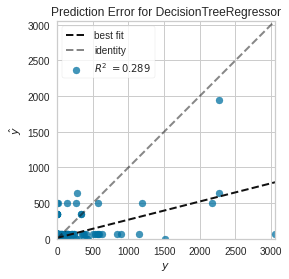

In [ ]:
# Calculate RMSE and R^2 for training data
train_y_pred = regressor.predict(X_train)# Predictions for training data
train_y_true = y_train # True values for training data

Training_MSE = mse(train_y_true, train_y_pred)
Training_RMSE = np.sqrt(Training_MSE)

Training_R_squared = r2_score(train_y_true, train_y_pred)

# Calculate RMSE and R^2 for testing data
test_y_pred = regressor.predict(X_test) # Predictions for testing data
test_y_true = y_test # True values for testing data

Testing_MSE = mse(test_y_true, test_y_pred)
Testing_RMSE = np.sqrt(Testing_MSE)

Testing_R_squared = r2_score(test_y_true, test_y_pred)

# Print evaluation metrics
print("\nTraining RMSE: ", np.round(Training_RMSE, 2))
print("Training R-Squared: ", np.round(Training_R_squared, 2))

print("\nTesting RMSE: ", np.round(Testing_RMSE, 2))
print("Testing R-Squared: ", np.round(Testing_R_squared, 2))

# Visualize the Prediction Error Plot
print("\nPrediction Error Plot")
viz = prediction_error(regressor, X_train, y_train, X_test, y_test)
viz.show()

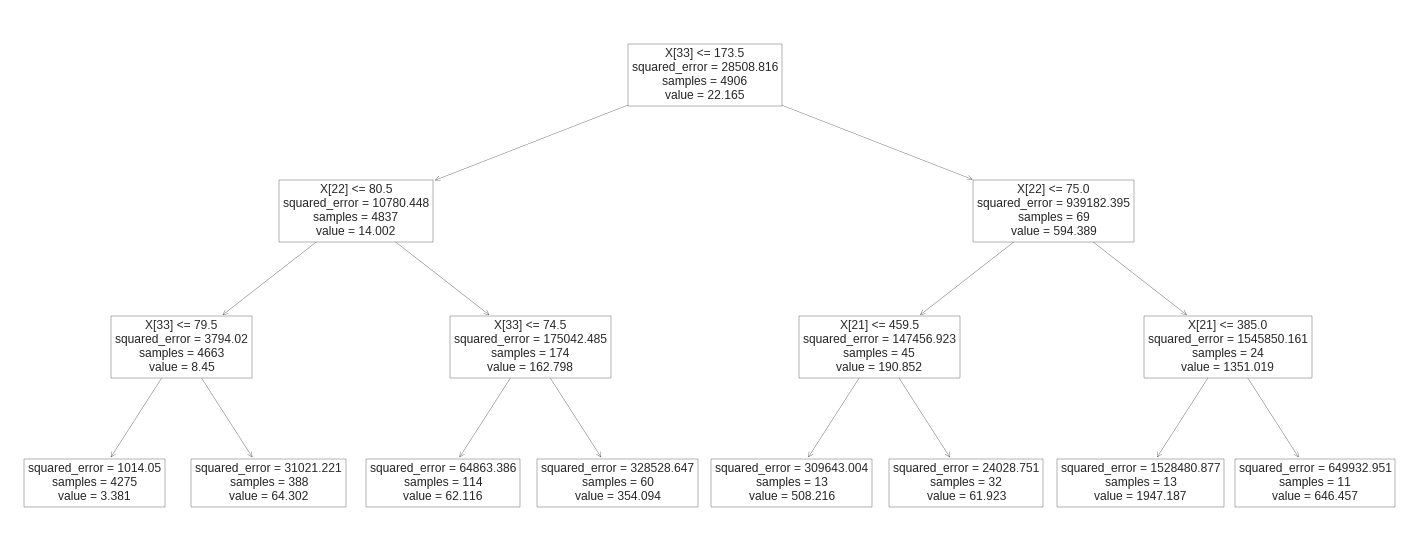

In [ ]:
# plot tree
plt.figure(figsize=(25,10))  # set plot size (denoted in inches)
tree.plot_tree(regressor,fontsize=12)
plt.show()

*Holdout Data*

In [ ]:
# Calculate average future revenue observed in the development dataset
AvgCLV = np.mean(dev_data['futureRevenue']) 

# Create naive estimate for all customers, which is equal to average future revenue from development dataset
holdout_data['NaiveEstimate'] = AvgCLV 

# Set up holdout data for initial model
X_holdout = holdout_data.drop(['fullVisitorId', 'firstPurchaseSessionTime','futureRevenue','NaiveEstimate'], axis=1) 
y_holdout = pd.Series(holdout_data.futureRevenue)

holdout_y_pred = regressor.predict(X_holdout) # Initial model predictions for holdout data
holdout_y_true = y_holdout # True values for holdout data

# Set up data for regression only model
dt_X_holdout = holdout_data[['revenue', 'visitNumber', 'hits', 'pageviews', 'timeOnSite', 'referralChannelGrouping', 
                             'organicSearchChannelGrouping', 'directChannelGrouping', 'paidSearchChannelGrouping', 'chromeBrowser', 
                             'safariBrowser', 'macintoshOS', 'windowsOS', 'chromeOS', 'LinuxOS', 'isMobile', 'california', 'newYork', 'bayArea', 'desktop', 'tablet', 'hit_checkstep', 'productQuantityPurchased', 'apparelPurchased', 'officePurchased', 'drinkwarePurchased', 'lifestylePurchased', 'bagsPurchased', 'electronicsPurchased', 'removedItemFromCart', 'firstWeekVisits', 'firstWeekTransactions', 'firstWeekRevenue', 'Frequency', 'purchase_interval_hr', 'buy_weekend']]

dt_holdout_y_pred = regressor.predict(dt_X_holdout) # Regression only predictions for holdout data'''


# Get RMSE and MAE error based on naive estimate
Naive_MAE = np.mean(np.absolute(pd.Series(holdout_data.NaiveEstimate) - holdout_y_true))
Naive_MSE = mse(pd.Series(holdout_data.NaiveEstimate), holdout_y_true)
Naive_RMSE = np.sqrt(Naive_MSE)
Naive_Avg_Error = np.mean(pd.Series(holdout_data.NaiveEstimate) - holdout_y_true)

# Get RMSE, MAE, and average error based on initial model predictions
Initial_Model_MAE = np.mean(np.absolute(holdout_y_true - holdout_y_pred))
Initial_Model_MSE = mse(holdout_y_true, holdout_y_pred)
Initial_Model_RMSE = np.sqrt(Initial_Model_MSE)
Initial_Model_Avg_Error = np.mean(holdout_y_true - holdout_y_pred)

# Get RMSE and MAE error based on regression only model
dt_Model_MAE = np.mean(np.absolute(holdout_y_true - dt_holdout_y_pred))
dt_Model_MSE = mse(holdout_y_true, dt_holdout_y_pred)
dt_Model_RMSE = np.sqrt(dt_Model_MSE)
dt_Model_Avg_Error = np.mean(dt_holdout_y_pred - holdout_y_true)

print("\nNaive MAE: ", np.round(Naive_MAE, 2))
print("Naive RMSE: ", np.round(Naive_RMSE, 2))
print("Naive Avg Error: ", np.round(Naive_Avg_Error, 2))

print("\nInitial Model MAE: ", np.round(Initial_Model_MAE, 2))
print("Initial Model RMSE: ", np.round(Initial_Model_RMSE, 2))
print("Initial Model Avg Error: ", np.round(Initial_Model_Avg_Error, 2))

print("\nRegression Only Model MAE: ", np.round(dt_Model_MAE, 2))
print("Regression Only Model RMSE: ", np.round(dt_Model_RMSE, 2))
print("Regression Only Model Avg Error: ", np.round(dt_Model_Avg_Error, 2))


Naive MAE:  31.19
Naive RMSE:  70.13
Naive Avg Error:  10.35

Initial Model MAE:  19.02
Initial Model RMSE:  72.68
Initial Model Avg Error:  1.98

Regression Only Model MAE:  19.02
Regression Only Model RMSE:  72.68
Regression Only Model Avg Error:  -1.98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### **3. Randomforest Regression**

In [ ]:
from sklearn import preprocessing
import pandas as pd

In [ ]:
# Use numpy to convert to arrays
import numpy as np
# Labels are the values we want to predict
labels = np.array(dev_data['futureRevenue'])
# Remove the labels from the features
# axis 1 refers to the columns
Forest= dev_data.drop(['fullVisitorId', 'firstPurchaseSessionTime','futureRevenue'], axis=1)
# Saving feature names for later use
feature_list = list(Forest.columns)
# Convert to numpy array
features = np.array(Forest)

In [ ]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state = 123)

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(max_depth = 5, n_estimators = 100, random_state = 123)
# Train the model on training data
rf.fit(train_features, train_labels);

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 23.37 degrees.


In [ ]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names= feature_list , rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

In [ ]:
# Limit depth of tree to 5 levels
rf_small = RandomForestRegressor(n_estimators=30, max_depth = 5)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Frequency            Importance: 0.331
Variable: productQuantityPurchased Importance: 0.1871
Variable: hit_checkstep        Importance: 0.0856
Variable: hits                 Importance: 0.0831
Variable: revenue              Importance: 0.0692
Variable: timeOnSite           Importance: 0.0497
Variable: pageviews            Importance: 0.0373
Variable: visitNumber          Importance: 0.0289
Variable: firstWeekRevenue     Importance: 0.019
Variable: purchase_interval_hr Importance: 0.0175
Variable: firstWeekVisits      Importance: 0.0173
Variable: chromeBrowser        Importance: 0.0115
Variable: chromeOS             Importance: 0.0112
Variable: lifestylePurchased   Importance: 0.0099
Variable: directChannelGrouping Importance: 0.0066
Variable: paidSearchChannelGrouping Importance: 0.0047
Variable: officePurchased      Importance: 0.0038
Variable: buy_weekend          Importance: 0.0037
Variable: apparelPurchased     Importance: 0.0031
Variable: bagsPurchased        Importance:

In [ ]:
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 23.37 degrees.
Accuracy: -inf %.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


*Training/Testing Statistics*


Training RMSE:  80.64
Training R-Squared:  0.77

Testing RMSE:  125.68
Testing R-Squared:  0.44

Prediction Error Plot


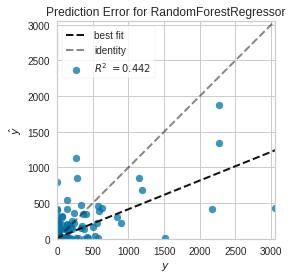

In [ ]:
# Calculate RMSE and R^2 for training data
train_y_pred = rf_small.predict(train_features) # Predictions for training data
train_y_true = train_labels # True values for training data

Training_MSE = mse(train_y_true, train_y_pred)
Training_RMSE = np.sqrt(Training_MSE)

Training_R_squared = r2_score(train_y_true, train_y_pred)

# Calculate RMSE and R^2 for testing data
test_y_pred = rf_small.predict(test_features) # Predictions for testing data
test_y_true = test_labels # True values for testing data

Testing_MSE = mse(test_y_true, test_y_pred)
Testing_RMSE = np.sqrt(Testing_MSE)

Testing_R_squared = r2_score(test_y_true, test_y_pred)

# Print evaluation metrics
print("\nTraining RMSE: ", np.round(Training_RMSE, 2))
print("Training R-Squared: ", np.round(Training_R_squared, 2))

print("\nTesting RMSE: ", np.round(Testing_RMSE, 2))
print("Testing R-Squared: ", np.round(Testing_R_squared, 2))

# Visualize the Prediction Error Plot
print("\nPrediction Error Plot")
viz = prediction_error(rf_small, train_features, train_labels , test_features, test_labels)
viz.show() # Sometimes visualization fails after using PyCaret EDA... Have to restart runtime and skip EDA

*Holdout Predictions*

In [ ]:
# Calculate average future revenue observed in the development dataset
AvgCLV = np.mean(dev_data['futureRevenue']) 

# Create naive estimate for all customers, which is equal to average future revenue from development dataset
holdout_data['NaiveEstimate'] = AvgCLV 

# Set up holdout data for initial model
X_holdout = holdout_data.drop(['fullVisitorId', 'firstPurchaseSessionTime','futureRevenue','NaiveEstimate'], axis=1) 
y_holdout = pd.Series(holdout_data.futureRevenue)

# Set up data for regression only model
X_holdout = holdout_data[['revenue', 'visitNumber', 'hits', 'pageviews', 'timeOnSite', 'referralChannelGrouping', 
                             'organicSearchChannelGrouping', 'directChannelGrouping', 'paidSearchChannelGrouping', 'chromeBrowser', 
                             'safariBrowser', 'macintoshOS', 'windowsOS', 'chromeOS', 'LinuxOS', 'isMobile', 'california', 'newYork', 'bayArea', 'desktop', 'tablet', 'hit_checkstep', 'productQuantityPurchased', 'apparelPurchased', 'officePurchased', 'drinkwarePurchased', 'lifestylePurchased', 'bagsPurchased', 'electronicsPurchased', 'removedItemFromCart', 'firstWeekVisits', 'firstWeekTransactions', 'firstWeekRevenue', 'Frequency', 'purchase_interval_hr', 'buy_weekend']]


holdout_y_pred = rf_small.predict(X_holdout) # Initial model predictions for holdout data
holdout_y_true = y_holdout # True values for holdout data

# Get RMSE, MAE, and average error based on Random Forest predictions
RF_Model_MAE = np.mean(np.absolute(holdout_y_true - holdout_y_pred))
RF_Model_MSE = mse(holdout_y_true, holdout_y_pred)
RF_Model_RMSE = np.sqrt(RF_Model_MSE)
RF_Model_Avg_Error = np.mean(holdout_y_true - holdout_y_pred)

print("\nRandom Forest Model MAE: ", np.round(RF_Model_MAE, 2))
print("Random Forest Model RMSE: ", np.round(RF_Model_RMSE, 2))
print("Random Forest Model Avg Error: ", np.round(RF_Model_Avg_Error, 2))




Random Forest Model MAE:  16.14
Random Forest Model RMSE:  65.36
Random Forest Model Avg Error:  0.74


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


### **4. XGBoost Regression**

In [ ]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, r2_score, precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_origin,y, test_size=0.2, 
                                                    random_state=123, shuffle=True)

xg_model = xgb.XGBRegressor(max_depth=5, n_estimators=30,
                           reg_alpha=10, reg_lambda=0,
                           objectvie='reg:squarederror', booster='gbtree',
                           random_state=123, learning_rate=0.10)

# Fit the data(train the model)
xg_model.fit(X_train, y_train)

# Calculate RMSE and R^2 for training data
train_y_pred = xg_model.predict(X_train) # Predictions for training data
train_y_true = y_train # True values for training data

Training_MSE = mse(train_y_true, train_y_pred)
Training_RMSE = np.sqrt(Training_MSE)

Training_R_squared = r2_score(train_y_true, train_y_pred)

# Calculate RMSE and R^2 for testing data
test_y_pred = xg_model.predict(X_test) # Predictions for testing data
test_y_true = y_test # True values for testing data

Testing_MSE = mse(test_y_true, test_y_pred)
Testing_RMSE = np.sqrt(Testing_MSE)

Testing_R_squared = r2_score(test_y_true, test_y_pred)

# Print evaluation metrics
print("\nTraining RMSE: ", np.round(Training_RMSE, 2))
print("Training R-Squared: ", np.round(Training_R_squared, 2))

print("\nTesting RMSE: ", np.round(Testing_RMSE, 2))
print("Testing R-Squared: ", np.round(Testing_R_squared, 2))

[08:26:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Training RMSE:  53.36
Training R-Squared:  0.9

Testing RMSE:  121.11
Testing R-Squared:  0.48



Prediction Error Plot


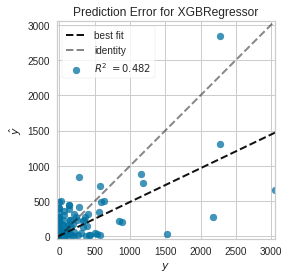

In [ ]:
print("\nPrediction Error Plot")
viz = prediction_error(xg_model, X_train, y_train, X_test, y_test)
viz.show()

*Feature Importance*

In [ ]:
#Feature Importance from XGB
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

In [ ]:
print(importances)

                       Attribute  Importance
34          purchase_interval_hr    0.291590
33                     Frequency    0.176685
31         firstWeekTransactions    0.102268
2                           hits    0.058537
32              firstWeekRevenue    0.040514
10                 safariBrowser    0.018618
8      paidSearchChannelGrouping    0.015620
5        referralChannelGrouping    0.013943
15                      isMobile    0.013768
28          electronicsPurchased    0.013700
27                 bagsPurchased    0.013659
30               firstWeekVisits    0.013601
26            lifestylePurchased    0.012488
3                      pageviews    0.012048
1                    visitNumber    0.012004
13                      chromeOS    0.011951
14                       LinuxOS    0.011895
23              apparelPurchased    0.011467
22      productQuantityPurchased    0.011254
16                    california    0.011001
9                  chromeBrowser    0.010982
0         

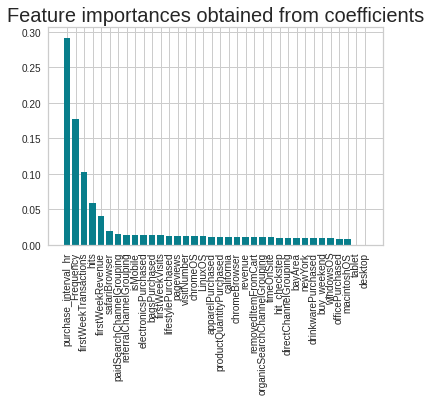

In [ ]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

*Hold out data*

In [ ]:
# Calculate average future revenue observed in the development dataset
AvgCLV = np.mean(dev_data['futureRevenue']) 

# Create naive estimate for all customers, which is equal to average future revenue from development dataset
holdout_data['NaiveEstimate'] = AvgCLV 

# Set up holdout data for initial model
X_holdout = holdout_data.drop(['fullVisitorId', 'firstPurchaseSessionTime','futureRevenue','NaiveEstimate'], axis=1) 
y_holdout = pd.Series(holdout_data.futureRevenue)

holdout_y_pred = xg_model.predict(X_holdout) # Initial model predictions for holdout data
holdout_y_true = y_holdout # True values for holdout data

# Set up data for regression only model
xg_X_holdout = holdout_data[['revenue', 'visitNumber', 'hits', 'pageviews', 'timeOnSite', 'referralChannelGrouping', 
                             'organicSearchChannelGrouping', 'directChannelGrouping', 'paidSearchChannelGrouping', 'chromeBrowser', 
                             'safariBrowser', 'macintoshOS', 'windowsOS', 'chromeOS', 'LinuxOS', 'isMobile', 'california', 'newYork', 'bayArea', 'desktop', 'tablet', 'hit_checkstep', 'productQuantityPurchased', 'apparelPurchased', 'officePurchased', 'drinkwarePurchased', 'lifestylePurchased', 'bagsPurchased', 'electronicsPurchased', 'removedItemFromCart', 'firstWeekVisits', 'firstWeekTransactions', 'firstWeekRevenue', 'Frequency', 'purchase_interval_hr', 'buy_weekend']]

xg_holdout_y_pred = xg_model.predict(xg_X_holdout) # Regression only predictions for holdout data'''


# Get RMSE and MAE error based on naive estimate
Naive_MAE = np.mean(np.absolute(pd.Series(holdout_data.NaiveEstimate) - holdout_y_true))
Naive_MSE = mse(pd.Series(holdout_data.NaiveEstimate), holdout_y_true)
Naive_RMSE = np.sqrt(Naive_MSE)
Naive_Avg_Error = np.mean(pd.Series(holdout_data.NaiveEstimate) - holdout_y_true)

# Get RMSE, MAE, and average error based on initial model predictions
Initial_Model_MAE = np.mean(np.absolute(holdout_y_true - holdout_y_pred))
Initial_Model_MSE = mse(holdout_y_true, holdout_y_pred)
Initial_Model_RMSE = np.sqrt(Initial_Model_MSE)
Initial_Model_Avg_Error = np.mean(holdout_y_true - holdout_y_pred)

# Get RMSE and MAE error based on regression only model
xg_Model_MAE = np.mean(np.absolute(holdout_y_true - xg_holdout_y_pred))
xg_Model_MSE = mse(holdout_y_true, xg_holdout_y_pred)
xg_Model_RMSE = np.sqrt(xg_Model_MSE)
xg_Model_Avg_Error = np.mean(xg_holdout_y_pred - holdout_y_true)

print("\nNaive MAE: ", np.round(Naive_MAE, 2))
print("Naive RMSE: ", np.round(Naive_RMSE, 2))
print("Naive Avg Error: ", np.round(Naive_Avg_Error, 2))

print("\nInitial Model MAE: ", np.round(Initial_Model_MAE, 2))
print("Initial Model RMSE: ", np.round(Initial_Model_RMSE, 2))
print("Initial Model Avg Error: ", np.round(Initial_Model_Avg_Error, 2))

print("\nRegression Only Model MAE: ", np.round(xg_Model_MAE, 2))
print("Regression Only Model RMSE: ", np.round(xg_Model_RMSE, 2))
print("Regression Only Model Avg Error: ", np.round(xg_Model_Avg_Error, 2))


Naive MAE:  31.19
Naive RMSE:  70.13
Naive Avg Error:  10.35

Initial Model MAE:  15.58
Initial Model RMSE:  73.19
Initial Model Avg Error:  0.03

Regression Only Model MAE:  15.58
Regression Only Model RMSE:  73.19
Regression Only Model Avg Error:  -0.03


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Classification Model

In [ ]:
# creating categorical variable for high future revenue
dev_data['has_futureRev'] = [np.nan for i in range(len(dev_data.index))]
dev_data.loc[dev_data.futureRevenue > 0, 'has_futureRev'] = 1
dev_data.loc[dev_data.futureRevenue <= 0, 'has_futureRev'] = 0

In [ ]:
# creating categorical variable for high future revenue
holdout_data['has_futureRev'] = [np.nan for i in range(len(holdout_data.index))]
holdout_data.loc[holdout_data.futureRevenue > 0, 'has_futureRev'] = 1
holdout_data.loc[holdout_data.futureRevenue <= 0, 'has_futureRev'] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
dev_data.groupby('has_futureRev').describe()

revenue                                                          \
                count        mean         std   min      25%    50%       75%   
has_futureRev                                                                   
0.0            5692.0  102.171720  212.476818  0.01  22.7975  44.79   95.9725   
1.0             441.0  222.602268  366.165444  1.99  41.3300  89.90  239.5000   

                      visitNumber            ... purchase_interval_hr         \
                  max       count      mean  ...                  75%    max   
has_futureRev                                ...                               
0.0            4847.6      5692.0  2.647927  ...                169.0  169.0   
1.0            4198.5       441.0  3.936508  ...                169.0  169.0   

              buy_weekend                                               
                    count      mean       std  min  25%  50%  75%  max  
has_futureRev                                                           
0.0                5692.0  0.325193  0.468488  0.0  0.0  0.0  1.0  1.0  
1.0                 441.0  0.283447  0.451183  0.0  0.0  0.0  1.0  1.0  

[2 rows x 296 columns]

In [ ]:
# Setup the data for Standardization and SK Learn
X_origin = dev_data.drop(['fullVisitorId', 'firstPurchaseSessionTime','futureRevenue', 'has_futureRev'], axis=1)
y = pd.Series(dev_data.has_futureRev) # Target vector in pd.Series format

In [ ]:
import xgboost as xgb
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, r2_score, precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [ ]:
# Making train and test sets for both X and y
X_train, X_test, y_train, y_test = train_test_split(X_origin,y, test_size=0.2, 
                                                    random_state=123, shuffle=True)
import statsmodels.api as sm
logit_model=sm.Logit(y,X_origin)
result=logit_model.fit()
print(result.summary2())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.081601
         Iterations 10
                                Results: Logit
Model:                    Logit                Pseudo R-squared:     0.684    
Dependent Variable:       has_futureRev        AIC:                  1072.9221
Date:                     2022-04-07 21:20     BIC:                  1314.8939
No. Observations:         6133                 Log-Likelihood:       -500.46  
Df Model:                 35                   LL-Null:              -1585.6  
Df Residuals:             6097                 LLR p-value:          0.0000   
Converged:                1.0000               Scale:                1.0000   
No. Iterations:           10.0000                                             
------------------------------------------------------------------------------
                              Coef.  Std.Err.    z     P>|z|   [0.025   0.975]
------------------------------------------------------------

## IMBALANCED DATA SOLUTION

In [ ]:
# check the distribution of y
y.value_counts()/y.shape[0]

0.0    0.928094
1.0    0.071906
Name: has_futureRev, dtype: float64

**(1) Logistic Regression with class-weights**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_origin, y, test_size=0.2, random_state=123)

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
# define class weights
w = {0:7, 1:93}
# define model
lg = LogisticRegression(random_state=123, class_weight=w)
# fit it
lg.fit(X_train,y_train)
# test
y_pred = lg.predict(X_test)
# performance
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')
print(classification_report(y_test, y_pred))

Confusion Matrix: 
[[1121   25]
 [   2   79]]
Accuracy Score: 0.9779951100244498
Area Under Curve: 0.9767468166246526
Recall score: 0.9753086419753086
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      1146
         1.0       0.76      0.98      0.85        81

    accuracy                           0.98      1227
   macro avg       0.88      0.98      0.92      1227
weighted avg       0.98      0.98      0.98      1227



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Predictions on Hold Out Data

In [ ]:
# Calculate average future revenue observed in the development dataset
AvgCLV = np.mean(dev_data['has_futureRev']) 

# Create naive estimate for all customers, which is equal to average future revenue from development dataset
holdout_data['NaiveEstimate'] = AvgCLV 

# Set up holdout data for initial model
#X_holdout_vif = holdout_data.drop(['fullVisitorId', 'firstPurchaseSessionTime','futureRevenue','NaiveEstimate','hits', 'pageviews','referralChannelGrouping', 'organicSearchChannelGrouping','chromeBrowser','macintoshOS','windowsOS','chromeOS','LinuxOS','isMobile','desktop','purchase_interval_hr'], axis=1) 
X_holdout = holdout_data.drop(['fullVisitorId', 'firstPurchaseSessionTime','futureRevenue','NaiveEstimate','has_futureRev'], axis=1) 
y_holdout = pd.Series(holdout_data.has_futureRev)

holdout_y_pred = lg.predict(X_holdout) # Initial model predictions for holdout data
holdout_y_true = y_holdout # True values for holdout data

# Set up data for regression only model
# reg_X_holdout = holdout_data[['revenue','pageviews','referralChannelGrouping','directChannelGrouping','electronicsPurchased','officePurchased','chromeOS','productQuantityPurchased','firstWeekRevenue']]
reg_X_holdout = X_holdout
reg_holdout_y_pred = lg.predict(reg_X_holdout)# Regression only predictions for holdout data


# Get RMSE and MAE error based on naive estimate
Naive_MAE = np.mean(np.absolute(pd.Series(holdout_data.NaiveEstimate) - holdout_y_true))
Naive_MSE = mse(pd.Series(holdout_data.NaiveEstimate), holdout_y_true)
Naive_RMSE = np.sqrt(Naive_MSE)
Naive_Avg_Error = np.mean(pd.Series(holdout_data.NaiveEstimate) - holdout_y_true)

# Get RMSE, MAE, and average error based on initial model predictions
Initial_Model_MAE = np.mean(np.absolute(holdout_y_true - holdout_y_pred))
Initial_Model_MSE = mse(holdout_y_true, holdout_y_pred)
Initial_Model_RMSE = np.sqrt(Initial_Model_MSE)
Initial_Model_Avg_Error = np.mean(holdout_y_true - holdout_y_pred)

# Get RMSE and MAE error based on regression only model
Reg_Model_MAE = np.mean(np.absolute(holdout_y_true - reg_holdout_y_pred))
Reg_Model_MSE = mse(holdout_y_true, reg_holdout_y_pred)
Reg_Model_RMSE = np.sqrt(Reg_Model_MSE)
Reg_Model_Avg_Error = np.mean(reg_holdout_y_pred - holdout_y_true)

print(confusion_matrix(holdout_y_true, holdout_y_pred))
print(classification_report(holdout_y_true, holdout_y_pred))
print(f'Accuracy Score: {accuracy_score(holdout_y_true,holdout_y_pred)}')
print(f'Area Under Curve: {roc_auc_score(holdout_y_true, holdout_y_pred)}')
print(f'Recall score: {recall_score(holdout_y_true,holdout_y_pred)}')

[[693  20]
 [  2  56]]
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98       713
         1.0       0.74      0.97      0.84        58

    accuracy                           0.97       771
   macro avg       0.87      0.97      0.91       771
weighted avg       0.98      0.97      0.97       771

Accuracy Score: 0.9714656290531777
Area Under Curve: 0.9687333752478601
Recall score: 0.9655172413793104


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


**(2) Random Forest With Random Undersampling**

n_estimators: number of trees

In [ ]:
#Importing essential libraries
import matplotlib.pyplot as plt
from statistics import mean
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import plot_confusion_matrix
from imblearn.ensemble import BalancedRandomForestClassifier

In [ ]:
#Build BSRF model
BRFC = BalancedRandomForestClassifier(n_estimators=20, random_state=123)
#Create Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=123)
scoring = ('f1', 'recall', 'precision')
#Evaluate BRFC model
scores = cross_validate(BRFC, X_origin, y, scoring=scoring, cv=cv)
#Get average evaluation metrics
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))

#Randomly spilt dataset to test and train set
X_train, X_test, y_train, y_test = train_test_split(X_origin, y, test_size=0.2, random_state=123)
#Train BRFC
BRFC.fit(X_train, y_train)
#BRFC prediction result
y_pred = BRFC.predict(X_test)
# performance
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')
print(classification_report(y_test, y_pred))

Mean f1: 0.563
Mean recall: 0.887
Mean precision: 0.413
Confusion Matrix: 
[[1029  106]
 [   9   83]]
Accuracy Score: 0.9062754686226568
Area Under Curve: 0.9043909212794484
Recall score: 0.9021739130434783
              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95      1135
         1.0       0.44      0.90      0.59        92

    accuracy                           0.91      1227
   macro avg       0.72      0.90      0.77      1227
weighted avg       0.95      0.91      0.92      1227



Predictions on Hold Out Data

In [ ]:
# Calculate average future revenue observed in the development dataset
AvgCLV = np.mean(dev_data['has_futureRev']) 

# Create naive estimate for all customers, which is equal to average future revenue from development dataset
holdout_data['NaiveEstimate'] = AvgCLV 

# Set up holdout data for initial model
#X_holdout_vif = holdout_data.drop(['fullVisitorId', 'firstPurchaseSessionTime','futureRevenue','NaiveEstimate','hits', 'pageviews','referralChannelGrouping', 'organicSearchChannelGrouping','chromeBrowser','macintoshOS','windowsOS','chromeOS','LinuxOS','isMobile','desktop','purchase_interval_hr'], axis=1) 
X_holdout = holdout_data.drop(['fullVisitorId', 'firstPurchaseSessionTime','futureRevenue','NaiveEstimate','has_futureRev'], axis=1) 
y_holdout = pd.Series(holdout_data.has_futureRev)

holdout_y_pred = BRFC.predict(X_holdout) # Initial model predictions for holdout data
holdout_y_true = y_holdout # True values for holdout data

# Set up data for regression only model
# reg_X_holdout = holdout_data[['revenue','pageviews','referralChannelGrouping','directChannelGrouping','electronicsPurchased','officePurchased','chromeOS','productQuantityPurchased','firstWeekRevenue']]
reg_X_holdout = X_holdout
reg_holdout_y_pred = BRFC.predict(reg_X_holdout)# Regression only predictions for holdout data


# Get RMSE and MAE error based on naive estimate
Naive_MAE = np.mean(np.absolute(pd.Series(holdout_data.NaiveEstimate) - holdout_y_true))
Naive_MSE = mse(pd.Series(holdout_data.NaiveEstimate), holdout_y_true)
Naive_RMSE = np.sqrt(Naive_MSE)
Naive_Avg_Error = np.mean(pd.Series(holdout_data.NaiveEstimate) - holdout_y_true)

# Get RMSE, MAE, and average error based on initial model predictions
Initial_Model_MAE = np.mean(np.absolute(holdout_y_true - holdout_y_pred))
Initial_Model_MSE = mse(holdout_y_true, holdout_y_pred)
Initial_Model_RMSE = np.sqrt(Initial_Model_MSE)
Initial_Model_Avg_Error = np.mean(holdout_y_true - holdout_y_pred)

# Get RMSE and MAE error based on regression only model
Reg_Model_MAE = np.mean(np.absolute(holdout_y_true - reg_holdout_y_pred))
Reg_Model_MSE = mse(holdout_y_true, reg_holdout_y_pred)
Reg_Model_RMSE = np.sqrt(Reg_Model_MSE)
Reg_Model_Avg_Error = np.mean(reg_holdout_y_pred - holdout_y_true)

print(confusion_matrix(holdout_y_true, holdout_y_pred))
print(classification_report(holdout_y_true, holdout_y_pred))
print(f'Accuracy Score: {accuracy_score(holdout_y_true,holdout_y_pred)}')
print(f'Area Under Curve: {roc_auc_score(holdout_y_true, holdout_y_pred)}')
print(f'Recall score: {recall_score(holdout_y_true,holdout_y_pred)}')

[[666  47]
 [ 12  46]]
              precision    recall  f1-score   support

         0.0       0.98      0.93      0.96       713
         1.0       0.49      0.79      0.61        58

    accuracy                           0.92       771
   macro avg       0.74      0.86      0.78       771
weighted avg       0.95      0.92      0.93       771

Accuracy Score: 0.9234760051880675
Area Under Curve: 0.8635923973497123
Recall score: 0.7931034482758621


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


**(3) SVM with kernel=rbf**

In [ ]:
from sklearn.svm import SVC
# define class weights
w = {0:7, 1:93}
svclassifier = SVC(kernel='rbf', degree=8, class_weight=w)
svclassifier.fit(X_train, y_train)

SVC(class_weight={0: 7, 1: 93}, degree=8)

In [ ]:
y_pred = svclassifier.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')

[[1103   32]
 [  13   79]]
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      1135
         1.0       0.71      0.86      0.78        92

    accuracy                           0.96      1227
   macro avg       0.85      0.92      0.88      1227
weighted avg       0.97      0.96      0.96      1227

Accuracy Score: 0.9633251833740831
Area Under Curve: 0.9152509097873971
Recall score: 0.8586956521739131


Predictions on Hold Out Data

In [ ]:
# Calculate average future revenue observed in the development dataset
AvgCLV = np.mean(dev_data['has_futureRev']) 

# Create naive estimate for all customers, which is equal to average future revenue from development dataset
holdout_data['NaiveEstimate'] = AvgCLV 

# Set up holdout data for initial model
#X_holdout_vif = holdout_data.drop(['fullVisitorId', 'firstPurchaseSessionTime','futureRevenue','NaiveEstimate','hits', 'pageviews','referralChannelGrouping', 'organicSearchChannelGrouping','chromeBrowser','macintoshOS','windowsOS','chromeOS','LinuxOS','isMobile','desktop','purchase_interval_hr'], axis=1) 
X_holdout = holdout_data.drop(['fullVisitorId', 'firstPurchaseSessionTime','futureRevenue','NaiveEstimate','has_futureRev'], axis=1) 
y_holdout = pd.Series(holdout_data.has_futureRev)

holdout_y_pred = svclassifier.predict(X_holdout) # Initial model predictions for holdout data
holdout_y_true = y_holdout # True values for holdout data

# Set up data for regression only model
# reg_X_holdout = holdout_data[['revenue','pageviews','referralChannelGrouping','directChannelGrouping','electronicsPurchased','officePurchased','chromeOS','productQuantityPurchased','firstWeekRevenue']]
reg_X_holdout = X_holdout
reg_holdout_y_pred = svclassifier.predict(reg_X_holdout)# Regression only predictions for holdout data


# Get RMSE and MAE error based on naive estimate
Naive_MAE = np.mean(np.absolute(pd.Series(holdout_data.NaiveEstimate) - holdout_y_true))
Naive_MSE = mse(pd.Series(holdout_data.NaiveEstimate), holdout_y_true)
Naive_RMSE = np.sqrt(Naive_MSE)
Naive_Avg_Error = np.mean(pd.Series(holdout_data.NaiveEstimate) - holdout_y_true)

# Get RMSE, MAE, and average error based on initial model predictions
Initial_Model_MAE = np.mean(np.absolute(holdout_y_true - holdout_y_pred))
Initial_Model_MSE = mse(holdout_y_true, holdout_y_pred)
Initial_Model_RMSE = np.sqrt(Initial_Model_MSE)
Initial_Model_Avg_Error = np.mean(holdout_y_true - holdout_y_pred)

# Get RMSE and MAE error based on regression only model
Reg_Model_MAE = np.mean(np.absolute(holdout_y_true - reg_holdout_y_pred))
Reg_Model_MSE = mse(holdout_y_true, reg_holdout_y_pred)
Reg_Model_RMSE = np.sqrt(Reg_Model_MSE)
Reg_Model_Avg_Error = np.mean(reg_holdout_y_pred - holdout_y_true)

print(confusion_matrix(holdout_y_true, holdout_y_pred))
print(classification_report(holdout_y_true, holdout_y_pred))
print(f'Accuracy Score: {accuracy_score(holdout_y_true,holdout_y_pred)}')
print(f'Area Under Curve: {roc_auc_score(holdout_y_true, holdout_y_pred)}')
print(f'Recall score: {recall_score(holdout_y_true,holdout_y_pred)}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


[[694  19]
 [ 10  48]]
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       713
         1.0       0.72      0.83      0.77        58

    accuracy                           0.96       771
   macro avg       0.85      0.90      0.87       771
weighted avg       0.97      0.96      0.96       771

Accuracy Score: 0.9623865110246433
Area Under Curve: 0.9004691202785703
Recall score: 0.8275862068965517
